In [1]:
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools
import pickle
%matplotlib inline

In [2]:
recalc=True

In [3]:
t0=dt.datetime(2015,1,1) # 1st start date of run
if recalc:
    with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
        tmask=np.copy(fm.variables['tmask'])
        umask=np.copy(fm.variables['umask'])
        vmask=np.copy(fm.variables['vmask'])
        navlon=np.copy(fm.variables['nav_lon'])
        navlat=np.copy(fm.variables['nav_lat'])
        e3t_0=np.copy(fm.variables['e3t_0'])
        e3u_0=np.copy(fm.variables['e3u_0'])
        e3v_0=np.copy(fm.variables['e3v_0'])
        e1t=np.copy(fm.variables['e1t'])
        e2t=np.copy(fm.variables['e2t'])
        e1v=np.copy(fm.variables['e1v'])
        e2u=np.copy(fm.variables['e2u'])
        A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

    stm=np.shape(tmask)
    nlen=147#100
    dlist=[t0+dt.timedelta(days=ii*10) for ii in range(0,nlen)]
    sdir1='/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'

    tmaskC=np.copy(tmask)
    tmaskC[:,:,370:490,:12]=0
    tmaskC[:,:,887:,30:70]=0

In [4]:
if recalc:
    tlist=dlist
    NGlobalTot=dict()
    VolTot=dict()
    NO3Tot=dict()
    NH4Tot=dict()
    PONTot=dict()
    DONTot=dict()
    DiatTot=dict()
    MyriTot=dict()
    NanoTot=dict()
    MiZoTot=dict()
    changeNGlobalTot=dict()
    for idir in (sdir1,):
        fformat1='%d%b%y/'
        if idir.startswith('/data/eolson/MEOPAR/SS36runs/CedarRuns/'):
            fformatT='SalishSea_1h_*_ptrc_T_%Y%m%d-*.nc'
            fformatP='SalishSea_1h_*_ptrc_T_%Y%m%d-*.nc'
        #elif idir==sdir0:
        #    fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
        #    fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_grid_T.nc'
        elif idir==sdir1:
            fformatT='SalishSea_1d_%Y%m%d_%Y%m%d_ptrc_T.nc'
            fformatP='SalishSea_1d_%Y%m%d_%Y%m%d_carp_T.nc'
        sumNO3=np.zeros((len(tlist),stm[2],stm[3]))
        sumVol=np.zeros((len(tlist),stm[2],stm[3]))
        sumNH4=np.zeros((len(tlist),stm[2],stm[3]))
        sumPON=np.zeros((len(tlist),stm[2],stm[3]))
        sumDON=np.zeros((len(tlist),stm[2],stm[3]))
        sumDiat=np.zeros((len(tlist),stm[2],stm[3]))
        sumMyri=np.zeros((len(tlist),stm[2],stm[3]))
        sumNano=np.zeros((len(tlist),stm[2],stm[3]))
        sumMiZo=np.zeros((len(tlist),stm[2],stm[3]))
        ind=-1
        for idt0 in tlist:
            ind=ind+1
            cdir=idt0.strftime(fformat1).lower()
            iffT=idt0.strftime(fformatT)
            iffP=idt0.strftime(fformatP)
            if idir.startswith('/data/eolson/MEOPAR/SS36runs/CedarRuns/'):
                sffT=idir+iffT
                sffP=idir+iffP
            elif idir.startswith('/results/') or idir.startswith('/results2/') or ('link' in idir):
                sffT=idir+cdir+iffT
                sffP=idir+cdir+iffP
            print(sffT)
            f=nc.Dataset(glob.glob(sffT)[0])
            fP=nc.Dataset(glob.glob(sffP)[0])
            #if idir==sdir0:
            #    e3t=np.expand_dims((1+fP.variables['sossheig'][0,:,:]/np.sum(e3t_0*tmask,1)),0)*e3t_0
            if idir==sdir1:
                e3t=fP.variables['e3t'][:2,:,:,:]
            Vol=A*e3t
            sumVol[ind,:,:]=1e-3*np.sum(tmaskC[0,:6,:,:]*Vol[0,:6,:,:],0) #mmol/m3*m3*10^-3=mol
            sumNO3[ind,:,:]=1e-3*np.sum(tmaskC[0,:6,:,:]*Vol[0,:6,:,:]*f.variables['nitrate'][0,:6,:,:],0) #mmol/m3*m3*10^-3=mol
            sumNH4[ind,:,:]=1e-3*np.sum(tmaskC[0,:6,:,:]*Vol[0,:6,:,:]*f.variables['ammonium'][0,:6,:,:],0) #mmol/m3*m3*10^-3=mol
            sumPON[ind,:,:]=1e-3*np.sum(tmaskC[0,:6,:,:]*Vol[0,:6,:,:]*f.variables['particulate_organic_nitrogen'][0,:6,:,:],0) #mmol/m3*m3*10^-3=mol
            sumDON[ind,:,:]=1e-3*np.sum(tmaskC[0,:6,:,:]*Vol[0,:6,:,:]*f.variables['dissolved_organic_nitrogen'][0,:6,:,:],0) #mmol/m3*m3*10^-3=mol
            sumDiat[ind,:,:]=1e-3*np.sum(tmaskC[0,:6,:,:]*Vol[0,:6,:,:]*f.variables['diatoms'][0,:6,:,:],0) #mmol/m3*m3*10^-3=mol
            sumMyri[ind,:,:]=1e-3*np.sum(tmaskC[0,:6,:,:]*Vol[0,:6,:,:]*f.variables['ciliates'][0,:6,:,:],0) #mmol/m3*m3*10^-3=mol
            sumMiZo[ind,:,:]=1e-3*np.sum(tmaskC[0,:6,:,:]*Vol[0,:6,:,:]*f.variables['microzooplankton'][0,:6,:,:],0) #mmol/m3*m3*10^-3=mol
            f.close()
            fP.close()
        NGlobalTot[idir]=np.sum(np.sum(sumNO3+sumNH4+sumPON+sumDON+sumDiat+sumMyri+sumNano+sumMiZo,2),1)
        VolTot[idir]=np.sum(np.sum(sumVol,2),1)
        NO3Tot[idir]=np.sum(np.sum(sumNO3,2),1)
        NH4Tot[idir]=np.sum(np.sum(sumNH4,2),1)
        PONTot[idir]=np.sum(np.sum(sumPON,2),1)
        DONTot[idir]=np.sum(np.sum(sumDON,2),1)
        DiatTot[idir]=np.sum(np.sum(sumDiat,2),1)
        MyriTot[idir]=np.sum(np.sum(sumMyri,2),1)
        NanoTot[idir]=np.sum(np.sum(sumNano,2),1)
        MiZoTot[idir]=np.sum(np.sum(sumMiZo,2),1)
        changeNGlobalTot[idir]=[NGlobalTot[idir][ii+1]-NGlobalTot[idir][ii] for ii in range(0,len(tlist)-1)]

/data/eolson/results/MEOPAR/SS36runs/linkHC201812/01jan15/SalishSea_1d_20150101_20150101_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/11jan15/SalishSea_1d_20150111_20150111_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/21jan15/SalishSea_1d_20150121_20150121_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/31jan15/SalishSea_1d_20150131_20150131_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/10feb15/SalishSea_1d_20150210_20150210_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/20feb15/SalishSea_1d_20150220_20150220_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/02mar15/SalishSea_1d_20150302_20150302_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/12mar15/SalishSea_1d_20150312_20150312_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/22mar15/SalishSea_1d_20150322_20150322_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/01apr15/SalishSea_1d_20150401_20150401_ptrc_T.nc
/data/eols

/data/eolson/results/MEOPAR/SS36runs/linkHC201812/10apr17/SalishSea_1d_20170410_20170410_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/20apr17/SalishSea_1d_20170420_20170420_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/30apr17/SalishSea_1d_20170430_20170430_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/10may17/SalishSea_1d_20170510_20170510_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/20may17/SalishSea_1d_20170520_20170520_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/30may17/SalishSea_1d_20170530_20170530_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/09jun17/SalishSea_1d_20170609_20170609_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/19jun17/SalishSea_1d_20170619_20170619_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/29jun17/SalishSea_1d_20170629_20170629_ptrc_T.nc
/data/eolson/results/MEOPAR/SS36runs/linkHC201812/09jul17/SalishSea_1d_20170709_20170709_ptrc_T.nc
/data/eols

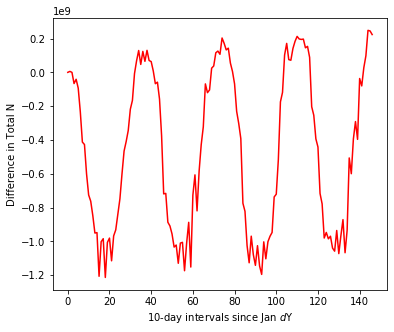

In [5]:
if recalc:
    #plt.plot(SiGlobalTot[sdir0]-SiGlobalTot[sdir0][0],'r-')
    #plt.plot(SiGlobalTot[sdir3]-SiGlobalTot[sdir3][0],'g-')
    #plt.plot(40,test-SiGlobalTot[sdir1][0],'r*')
    #plt.plot(40,test2-SiGlobalTot[sdir1][0],'k*')
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    ax.plot(NGlobalTot[sdir1]-NGlobalTot[sdir1][0],'r-')
    ax.set_xlabel('10-day intervals since '+t0.strftime('%b $d $Y'))
    ax.set_ylabel('Difference in Total N')

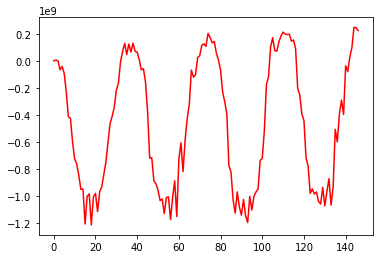

In [6]:
if recalc:
    plt.plot(NGlobalTot[sdir1]-NGlobalTot[sdir1][0],'r-')

In [7]:
if recalc:
    pickle.dump(NGlobalTot[sdir1],open('../../save/NGlobalTot_HC1812_upper6.pkl','wb'))

In [9]:
NGlobalTotHC=pickle.load(open('../../save/NGlobalTot_HC1812_upper6.pkl','rb'))

In [10]:
bdir='/data/eolson/MEOPAR/SS36runs/CedarRuns/'

In [11]:
tt=np.array([t0+dt.timedelta(10*ii) for ii in range(0,len(NGlobalTotHC))])

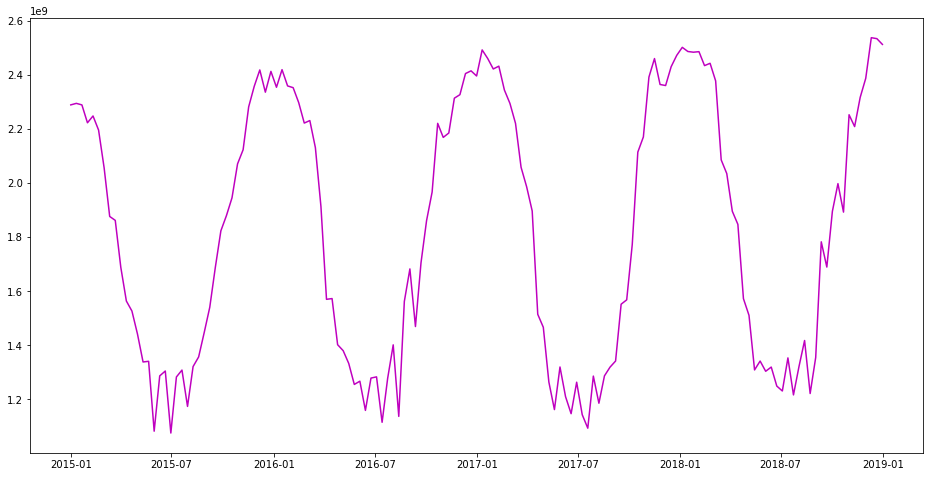

In [12]:
fig,ax=plt.subplots(1,1,figsize=(16,8))
plt.plot(tt,NGlobalTotHC,'m-')

In [13]:
1/4*(np.max(NGlobalTotHC[(tt>dt.datetime(2015,1,1))&(tt<dt.datetime(2016,1,1))])-
     np.min(NGlobalTotHC[(tt>dt.datetime(2015,6,1))&(tt<dt.datetime(2016,6,1))])+
     np.max(NGlobalTotHC[(tt>dt.datetime(2016,1,1))&(tt<dt.datetime(2017,1,1))])-
     np.min(NGlobalTotHC[(tt>dt.datetime(2016,6,1))&(tt<dt.datetime(2017,6,1))])+
     np.max(NGlobalTotHC[(tt>dt.datetime(2017,1,1))&(tt<dt.datetime(2018,1,1))])-
     np.min(NGlobalTotHC[(tt>dt.datetime(2017,6,1))&(tt<dt.datetime(2018,6,1))])+
     np.max(NGlobalTotHC[(tt>dt.datetime(2018,1,1))&(tt<dt.datetime(2019,1,1))])-
     np.min(NGlobalTotHC[(tt>dt.datetime(2018,6,1))&(tt<dt.datetime(2019,6,1))]))*1e-10

0.1341067395747956

[8.40046934e+05 1.76343530e+09]


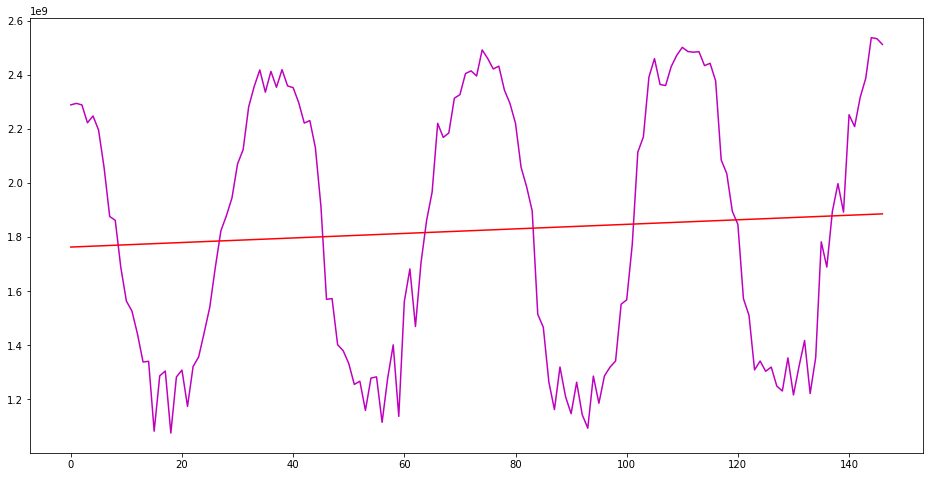

In [14]:
fig,ax=plt.subplots(1,1,figsize=(16,8))
xx=np.arange(0,len(NGlobalTotHC))
pf=np.polyfit(xx,NGlobalTotHC,1)
print(pf)
plt.plot(xx,NGlobalTotHC,'m-')
yy=pf[1]+pf[0]*xx
ax.plot(xx,yy,'r-')

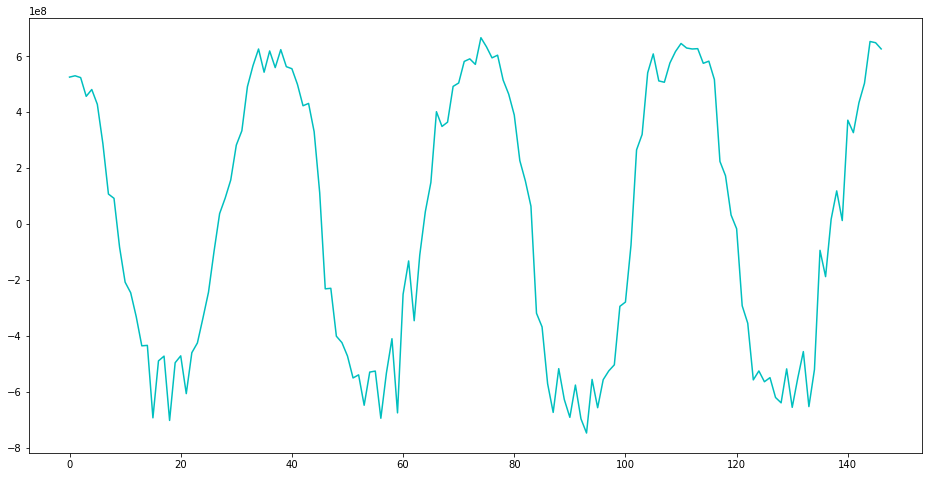

In [15]:
notrend=NGlobalTotHC-yy
fig,ax=plt.subplots(1,1,figsize=(16,8))
ax.plot(xx,notrend,'c-')


In [16]:
((yy[-1]-yy[0])/4)

30661713.09969741

In [17]:
(1/4*(np.max(notrend[(tt>dt.datetime(2015,1,1))&(tt<dt.datetime(2016,1,1))])-
     np.min(notrend[(tt>dt.datetime(2015,6,1))&(tt<dt.datetime(2016,6,1))])+
     np.max(notrend[(tt>dt.datetime(2016,1,1))&(tt<dt.datetime(2017,1,1))])-
     np.min(notrend[(tt>dt.datetime(2016,6,1))&(tt<dt.datetime(2017,6,1))])+
     np.max(notrend[(tt>dt.datetime(2017,1,1))&(tt<dt.datetime(2018,1,1))])-
     np.min(notrend[(tt>dt.datetime(2017,6,1))&(tt<dt.datetime(2018,6,1))])+
     np.max(notrend[(tt>dt.datetime(2018,1,1))&(tt<dt.datetime(2019,1,1))])-
     np.min(notrend[(tt>dt.datetime(2018,6,1))&(tt<dt.datetime(2019,6,1))])))

1342537477.882873

In [18]:
((yy[-1]-yy[0])/4)/(1/4*(np.max(NGlobalTotHC[(tt>dt.datetime(2015,1,1))&(tt<dt.datetime(2016,1,1))])-
     np.min(NGlobalTotHC[(tt>dt.datetime(2015,6,1))&(tt<dt.datetime(2016,6,1))])+
     np.max(NGlobalTotHC[(tt>dt.datetime(2016,1,1))&(tt<dt.datetime(2017,1,1))])-
     np.min(NGlobalTotHC[(tt>dt.datetime(2016,6,1))&(tt<dt.datetime(2017,6,1))])+
     np.max(NGlobalTotHC[(tt>dt.datetime(2017,1,1))&(tt<dt.datetime(2018,1,1))])-
     np.min(NGlobalTotHC[(tt>dt.datetime(2017,6,1))&(tt<dt.datetime(2018,6,1))])+
     np.max(NGlobalTotHC[(tt>dt.datetime(2018,1,1))&(tt<dt.datetime(2019,1,1))])-
     np.min(NGlobalTotHC[(tt>dt.datetime(2018,6,1))&(tt<dt.datetime(2019,6,1))])))*100

2.2863663076825755

In [19]:
((yy[-1]-yy[0])/4)/(1/4*(np.max(notrend[(tt>dt.datetime(2015,1,1))&(tt<dt.datetime(2016,1,1))])-
     np.min(notrend[(tt>dt.datetime(2015,6,1))&(tt<dt.datetime(2016,6,1))])+
     np.max(notrend[(tt>dt.datetime(2016,1,1))&(tt<dt.datetime(2017,1,1))])-
     np.min(notrend[(tt>dt.datetime(2016,6,1))&(tt<dt.datetime(2017,6,1))])+
     np.max(notrend[(tt>dt.datetime(2017,1,1))&(tt<dt.datetime(2018,1,1))])-
     np.min(notrend[(tt>dt.datetime(2017,6,1))&(tt<dt.datetime(2018,6,1))])+
     np.max(notrend[(tt>dt.datetime(2018,1,1))&(tt<dt.datetime(2019,1,1))])-
     np.min(notrend[(tt>dt.datetime(2018,6,1))&(tt<dt.datetime(2019,6,1))])))*100

2.2838627304505263

In [20]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
        tmask=np.copy(fm.variables['tmask'])
        e1t=np.copy(fm.variables['e1t'])
        e2t=np.copy(fm.variables['e2t'])
        e3t_0=np.copy(fm.variables['e3t_0'])
volSOG=np.sum(tmask[0,:6,:,:]*e1t[:,:,:]*e2t[:,:,:]*e3t_0[0,:6,:,:])

In [21]:
#concentration change per year:
((yy[-1]-yy[0])/4)/volSOG*1e3 # mol/m3*(10^6 umol/mol)*(10-3 m3/L)->umolN/L=uM N

0.28459205834608886